### 필요한 모듈 imoprt

In [1]:
# 필요한 모듈 import
import pandas as pd
import numpy as np
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글처리
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
# test 데이터 확인하기
test = pd.read_csv('test.csv', encoding='utf-8')

In [4]:
# test.info()

In [5]:
# 학습 데이터 로드
df = pd.read_csv('train.csv', encoding='utf-8')

In [6]:
# df.info()

<Axes: >

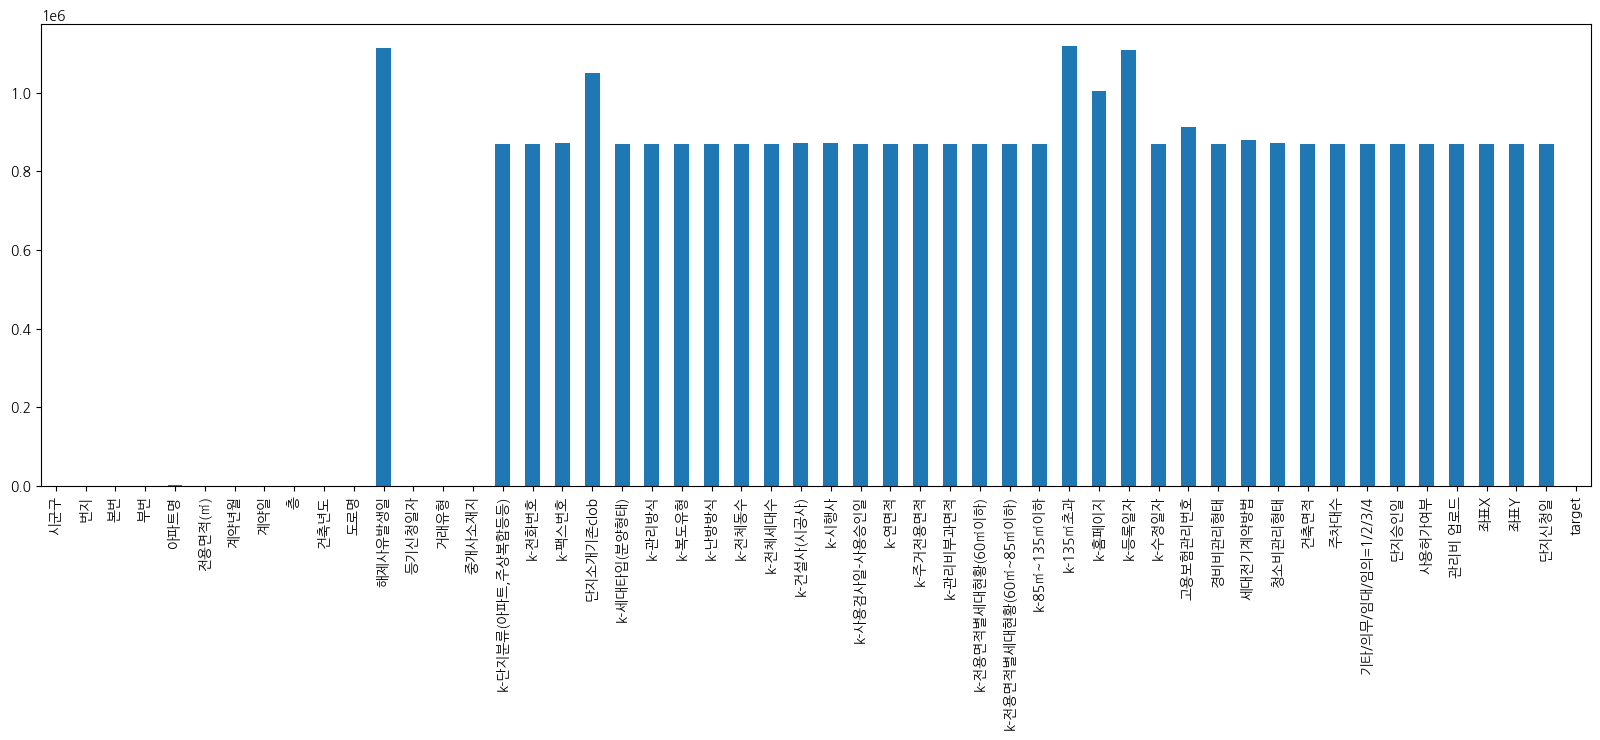

In [7]:
# 결측치 시각화
df.isnull().sum().plot(kind='bar', figsize=(20, 6))

In [8]:
# 계약년, 월 열 생성
df['계약년'] = df['계약년월'].astype('str').str[:4]
df['계약월'] = df['계약년월'].astype('str').str[4:]

In [9]:
test['계약년'] = test['계약년월'].astype('str').str[:4]
test['계약월'] = test['계약년월'].astype('str').str[4:]

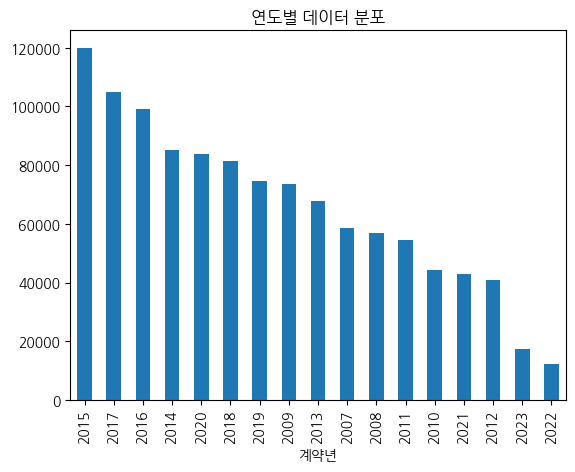

In [10]:
df['계약년'].value_counts().plot(kind='bar') # 2015부터 사용
plt.title('연도별 데이터 분포')
plt.show()
# plt.savefig('./visualization/연도별 데이터 분포.png')

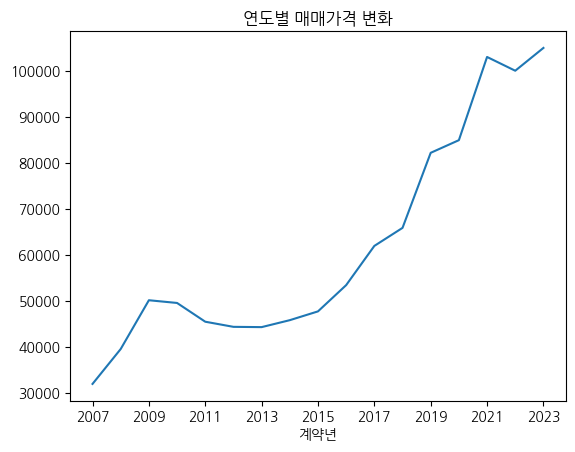

In [11]:
df.groupby('계약년')['target'].mean().plot()
plt.title('연도별 매매가격 변화')
plt.show()
# plt.savefig('./visualization/연도별 데이터 분포.png')

### 2015년부터 가격이 오르는 것을 확인, 2015년 데이터가 가장 많이 분포되어 있음

In [12]:
# 2015년부터 사용
print(f'전체 데이터 개수 : {len(df)}')
df = df[df['계약년'] >= '2015'].reset_index(drop=True)
print(f'2015년 이후 데이터 개수 : {len(df)}')

전체 데이터 개수 : 1118822
2015년 이후 데이터 개수 : 636736


### 결측치 확인

In [13]:
# train
null_per = df.isnull().mean()*100
null_per.sort_values(ascending=False)

k-135㎡초과                  99.963564
해제사유발생일                   99.060364
k-등록일자                    98.543666
단지소개기존clob                93.662523
k-홈페이지                    89.114170
고용보험관리번호                  81.234295
세대전기계약방법                  77.306922
k-팩스번호                    76.689868
k-시행사                     76.535487
청소비관리형태                   76.534388
k-건설사(시공사)                76.520253
경비비관리형태                   76.515699
k-단지분류(아파트,주상복합등등)        76.490257
k-전체동수                    76.479891
단지승인일                     76.451308
k-전화번호                    76.449580
k-복도유형                    76.405135
건축면적                      76.384718
주차대수                      76.384718
좌표Y                       76.381106
좌표X                       76.381106
단지신청일                     76.378436
k-사용검사일-사용승인일             76.377965
k-주거전용면적                  76.371369
k-85㎡~135㎡이하              76.371369
k-전용면적별세대현황(60㎡~85㎡이하)    76.371369
k-전용면적별세대현황(60㎡이하)        76.371369
k-수정일자                    76

In [14]:
# test
null_per = test.isnull().mean()*100
null_per.sort_values(ascending=False)

k-135㎡초과                  99.978430
해제사유발생일                   97.713546
단지소개기존clob                94.025022
k-등록일자                    92.256255
k-홈페이지                    84.943917
고용보험관리번호                  80.381795
세대전기계약방법                  71.635030
k-팩스번호                    71.246764
k-단지분류(아파트,주상복합등등)        70.987921
k-시행사                     70.966350
k-건설사(시공사)                70.955565
k-전체동수                    70.933995
k-전화번호                    70.923210
경비비관리형태                   70.890854
청소비관리형태                   70.890854
단지승인일                     70.836928
건축면적                      70.804573
k-복도유형                    70.793788
주차대수                      70.783003
k-사용검사일-사용승인일             70.783003
k-관리방식                    70.772217
k-85㎡~135㎡이하              70.772217
k-관리비부과면적                 70.772217
k-전용면적별세대현황(60㎡이하)        70.772217
k-전용면적별세대현황(60㎡~85㎡이하)    70.772217
k-주거전용면적                  70.772217
k-난방방식                    70.772217
k-전체세대수                   70

### 결측치 처리

In [15]:
def missing_value_over80(df):    
    # 결측치가 80% 이상인 열 제거
    
    n_cols = [col for col in df.columns if df[col].isnull().mean()*100 > 80]
    print(f'결측치 80% 이상인 열: {n_cols}')
    pre = df.shape[1]
    print(f'결측치 열 제거 전: {df.shape}')
    cols = [col for col in df.columns if df[col].isnull().mean()*100 < 80]
    df = df[cols]
    print(f'결측치 열 제거 후: {df.shape}')
    post = df.shape[1]
    print(f'총 {pre - post}개 열 제거')
    
    return df

In [16]:
print('train')
df = missing_value_over80(df)
print('test')
test = missing_value_over80(test)

train
결측치 80% 이상인 열: ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
결측치 열 제거 전: (636736, 54)
결측치 열 제거 후: (636736, 48)
총 6개 열 제거
test
결측치 80% 이상인 열: ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
결측치 열 제거 전: (9272, 53)
결측치 열 제거 후: (9272, 47)
총 6개 열 제거


In [17]:
def missing_value_process(df):
    # 세밀한 결측치 처리
    
    # 이상한 nan값 처리
    df['등기신청일자'] = df['등기신청일자'].replace(' ', None)
    df['거래유형'] = df['거래유형'].replace('-', None)
    df['중개사소재지'] = df['중개사소재지'].replace('-', None)

    # 층 마이너스 값 처리
    df.loc[df['층'] < 0, '층'] = 1

    # 아파트명 null값 처리
    df['아파트명'] = df['아파트명'].fillna(df['번지'])

    # 번지, 본번, 부번 null값 처리
    df.loc[df['아파트명'] == '힐스테이트 서초 젠트리스', '번지'] = '557'
    df.loc[df['아파트명'] == '서초포레스타2단지', '번지'] = '384'

    df.loc[df['아파트명'] == '힐스테이트 서초 젠트리스', '본번'] = 0
    df.loc[df['아파트명'] == '힐스테이트 서초 젠트리스', '부번'] = 0

    print(f'아파트명 결측치: {df["아파트명"].isnull().sum()}')
    print(f'번지 결측치: {df["번지"].isnull().sum()}')
    print(f'본번 결측치: {df["본번"].isnull().sum()}')
    print(f'부번 결측치: {df["부번"].isnull().sum()}')
    print(f'{df.shape} 세밀한 결측치 처리 완')
    return df

In [18]:
print('train')
df = missing_value_process(df)
print('test')
test = missing_value_process(test)

train
아파트명 결측치: 0
번지 결측치: 0
본번 결측치: 0
부번 결측치: 0
(636736, 48) 세밀한 결측치 처리 완
test
아파트명 결측치: 0
번지 결측치: 0
본번 결측치: 0
부번 결측치: 0
(9272, 47) 세밀한 결측치 처리 완


In [19]:
# test 아파트명 값 처리
fill_values = {
    4035: "INS새터아파트",
    4449: "상진아파트",
    8041: "유탑유블레스아파트",
    8042: "유탑유블레스아파트",
}

for idx, value in fill_values.items():
    test.loc[idx, "아파트명"] = value

In [20]:
# 연속형, 범주형 변수 결측치 처리 전 아파트명 브랜드화
def apt_branding(df):
    # 높은 거래가격 아파트명 브랜드화
    # 또한 주택, 번지로 되어 있는 아파트명 처리
    # 이를 그룹화하여 결측치 처리하기 위함.

    # 아파트명 브랜드
    brand_patterns = {
        "래미안": r"래미안|레미안",
        "힐스테이트": r"힐스테이트|디에이치",
        "자이": r"자이",
        "e편한세상": r"e-편한세상|이편한세상|e편한세상",
        "롯데캐슬": r"롯데캐슬|르엘",
        "아이파크": r"PARK",
        "푸르지오": r"푸르지오|써밋",
        "더샵": r"더샵",
        "센트레빌": r"센트레빌",
        "스위첸": r"스위첸",
        "유보라": r"유보라",
        "주공": r"주공|엘에이치|휴먼시아"
    }

    print(f'브랜드명 추가 전: {df.shape}')
    
    # 초기화
    df['브랜드명'] = '일반'

    # 브랜드별로 매칭
    for brand, pattern in brand_patterns.items():
        mask = df['아파트명'].str.contains(pattern, flags=re.IGNORECASE, regex=True)
        df.loc[mask, '브랜드명'] = brand

    print(f'{df.shape} 브랜드명 추가 완료')
    return df

In [21]:
print('train')
df = apt_branding(df)
print('test')
test = apt_branding(test)

train
브랜드명 추가 전: (636736, 48)
(636736, 49) 브랜드명 추가 완료
test
브랜드명 추가 전: (9272, 47)
(9272, 48) 브랜드명 추가 완료


In [22]:
# train/test 구 열 생성
df['구'] = df['시군구'].str.split(' ').str[1]
test['구'] = test['시군구'].str.split(' ').str[1]

In [23]:
# 연속형, 범주형 결측치 처리
def fillna_train_test_multilevel(train_df, test_df, group_hierarchy, exclude_cols=None):
    """
    다단계 fallback 결측치 처리 (train 기준으로 test 채움)
    
    Parameters
    ----------
    train_df : pd.DataFrame
        학습 데이터
    test_df : pd.DataFrame
        테스트 데이터
    group_hierarchy : list of list
        그룹 단계별 리스트, 예: [["구","계약년월","브랜드명"], ["구","계약년월"]]
    exclude_cols : list
        결측치 처리 제외할 컬럼
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    exclude_cols = exclude_cols or []
    
    num_cols = [c for c in train_df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
    cat_cols = [c for c in train_df.select_dtypes(include=["object","category"]).columns if c not in exclude_cols]

    # ---- train 결측치 처리 ----
    for col in num_cols:
        if col in exclude_cols: continue
        for group_cols in group_hierarchy:
            train_df[col] = train_df[col].fillna(train_df.groupby(group_cols)[col].transform("median"))

    for col in cat_cols:
        if col in exclude_cols: continue
        mode_func = lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        for group_cols in group_hierarchy:
            train_df[col] = train_df[col].fillna(train_df.groupby(group_cols)[col].transform(mode_func))

    # ---- test 결측치 처리 (train 기준 통계 사용) ----
    for col in num_cols:
        if col in exclude_cols: continue
        for group_cols in group_hierarchy:
            median_map = train_df.groupby(group_cols)[col].median()
            test_df[col] = test_df[col].fillna(test_df[group_cols].apply(tuple, axis=1).map(median_map))

    for col in cat_cols:
        if col in exclude_cols: continue
        for group_cols in group_hierarchy:
            mode_map = train_df.groupby(group_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            test_df[col] = test_df[col].fillna(test_df[group_cols].apply(tuple, axis=1).map(mode_map))

    print("Train & Test 결측치 처리 완료 (multi-level fallback)")
    print(f'train: {train_df.shape} / test: {test_df.shape}')
    return train_df, test_df

In [24]:
group_hierarchy = [["구","계약년월","브랜드명"], ["구","계약년월"]]
train_df, test_df = fillna_train_test_multilevel(
    df, test,
    group_hierarchy = group_hierarchy,
    exclude_cols=["좌표X", "좌표Y", 'target']
)

Train & Test 결측치 처리 완료 (multi-level fallback)
train: (636736, 50) / test: (9272, 49)


In [26]:
# null값을 찍어보니 3개 열에서 여전히 큰 결측치 값
# 거래유형, 중개사소재지는 '기타'로 처리
# 등기신청일자는 '알수없음'으로 처리

# train
# 등기신청일자
train_df['등기신청일자'] = train_df['등기신청일자'].fillna('알수없음')
# 거래유형
train_df['거래유형'] = train_df['거래유형'].fillna('기타')
# 중개사소재지
train_df['중개사소재지'] = train_df['중개사소재지'].fillna('기타')

# test
# 등기신청일자
test_df['등기신청일자'] = test_df['등기신청일자'].fillna('알수없음')
# 중개사소재지
test_df['중개사소재지'] = test_df['중개사소재지'].fillna('기타')

In [27]:
# 나머지 결측치 채우기
group_hierarchy = [["구", "건축년도"], ['구']]
train, test = fillna_train_test_multilevel(
    train_df, test_df,
    group_hierarchy = group_hierarchy,
    exclude_cols=["좌표X", "좌표Y", 'target']
)

Train & Test 결측치 처리 완료 (multi-level fallback)
train: (636736, 50) / test: (9272, 49)


In [28]:
# 나머지 test 결측치 채우기
# 범주형(알수없음)
for col in test.select_dtypes(include=["object","category"]).columns:
    test[col] = test[col].fillna("알수없음")
    
# 수치형(train의 중앙값)
num_cols = [col for col in test.select_dtypes(include=["number"]).columns if col not in ['좌표X', '좌표Y']]
for col in num_cols:
    if col in train.columns and test[col].isna().any():
        median_value = train[col].median()
        test[col] = test[col].fillna(median_value)

In [29]:
# 좌표 데이터 결측치 처리
# 네이버 API geocoding을 통해 위경도 정보 처리함.(naver_api_geocoding_xy.ipynb)
xy_train = pd.read_csv('xy_train.csv', encoding='utf-8')
xy_test = pd.read_csv('xy_test.csv', encoding='utf-8')

In [30]:
def add_xy_coordinate(df, xy_df):
    # 불필요한 열 제거
    xy_df = xy_df.drop('아파트명', axis=1)
    
    # merge를 위한 주소 열 생성
    df['주소'] = df['시군구'] + ' ' + df['번지']

    # 주소를 이용하여 결측치만 해당 xy좌표를 채움
    x_map = xy_df.set_index("주소")['x좌표'].to_dict()
    y_map = xy_df.set_index("주소")['y좌표'].to_dict()

    df['x좌표'] = df['좌표X'].fillna(df["주소"].map(x_map))
    df['y좌표'] = df['좌표Y'].fillna(df["주소"].map(y_map))

    print(f'이전: {df.shape}')

    # 이전 좌표 열은 삭제
    df = df.drop(['좌표X', '좌표Y'], axis=1)
    print(f'이후: {df.shape}')
    print(f'XY좌표 결측치 처리 완')
    
    return df

In [31]:
print('train')
train = add_xy_coordinate(train, xy_train)
print('\ntest')
test = add_xy_coordinate(test, xy_test)

train
이전: (636736, 53)
이후: (636736, 51)
XY좌표 결측치 처리 완

test
이전: (9272, 52)
이후: (9272, 50)
XY좌표 결측치 처리 완


### Feature Engineering

In [32]:
def feature_engineering(df):
    # 내부 데이터로 파생변수 생성
    # 전용면적 로그 변환
    df["전용면적(log)"] = np.log1p(df["전용면적(㎡)"])

    # 전용면적 구간화
    df["전용면적구간"] = 0
    
    df.loc[df['전용면적(㎡)'] < 59, '전용면적구간'] = '59㎡미만'
    df.loc[(df["전용면적(㎡)"] >= 59) & (df["전용면적(㎡)"] < 60), '전용면적구간'] = '약59㎡'
    df.loc[(df["전용면적(㎡)"] >= 60) & (df["전용면적(㎡)"] < 84), '전용면적구간'] = '60㎡이상84㎡미만'
    df.loc[(df["전용면적(㎡)"] >= 84) & (df["전용면적(㎡)"] < 85), '전용면적구간'] = '약84㎡'
    df.loc[df['전용면적(㎡)'] >= 85, '전용면적구간'] = '85㎡이상'
    
    # 전용면적 평수 변환
    df["평수"] = df["전용면적(㎡)"] / 3.3

    # 연식(계약년-건축년도)
    df['계약년'] = df['계약년'].astype('int')
    df['연식'] = df['계약년'] - df['건축년도']
    df.loc[df['연식'] < 0, '연식'] = 0

    # 신축 / 재건축 라벨링
    df['신축(10년 미만)'] = (df['연식'] < 10).astype(int)
    df['재건축 연한(30년 이상)'] = (df['연식'] >= 30).astype(int)
    
    # 강남권 여부
    df['강남권여부'] = df['구'].apply(lambda x: 1 if x in ['강남구', '서초구', '송파구'] else 0)

    # 우수학군
    df['우수학군'] = df['구'].apply(lambda x: 1 if x in ['강남구', '양천구', '노원구', '서초구', '송파구', '마포구'] else 0)

    # 프리미엄아파트 여부
    df['프리미엄아파트'] = df['구'].apply(lambda x: 1 if x in ['강남구', '용산구', '성동구'] else 0)
    
    # 층 구간화
    bins = [-15, 5, 15, float('inf')]
    labels = ["저층", "중층", "고층"]
    df["층"] = pd.cut(df["층"], bins = bins, labels = labels)

    # zone4 생성 및 원-핫 인코딩
    CBD = {'종로구','중구','용산구'}
    GANGNAM3 = {'강남구','서초구','송파구'}
    INNER = {'마포구','성동구','광진구','동대문구','서대문구','성북구','영등포구','양천구','동작구','관악구','강동구'}

    def map_zone(gu):
        if gu in CBD: return '도심'
        if gu in GANGNAM3: return '강남3'
        if gu in INNER: return '내부권'
        return '외곽'

    df['zone4'] = df['구'].map(map_zone)
    zone_dummies = pd.get_dummies(df['zone4'], prefix='zone4')
    df[zone_dummies.columns] = zone_dummies

    print(f'내부 데이터 feature engineering 완료: {df.shape}')
    return df

In [33]:
print('train')
train = feature_engineering(train)
print('\ntest')
test = feature_engineering(test)

train
내부 데이터 feature engineering 완료: (636736, 65)

test
내부 데이터 feature engineering 완료: (9272, 64)


### 외부데이터 feature 추가

#### 1. 대장아파트

In [34]:
# 대장아파트와 거리
def top_apt_dis(df):
    # 구별 대장아파트 목록
    lead_house = {
        "강서구" : (37.56520754904415, 126.82349451366355),
        "관악구" : (37.47800896704934, 126.94178722423047),
        "강남구" : (37.530594054209146, 127.0262701317293),
        "강동구" : (37.557175745977375, 127.16359581113558),
        "광진구" : (37.543083184171, 127.0998363490422),
        "구로구" : (37.51045944660659, 126.88687199829572),
        "금천구" : (37.459818907487936, 126.89741481874103),
        "노원구" : (37.63952738902813, 127.07234254197617),
        "도봉구" : (37.65775043994647, 127.04345013224447),
        "동대문구" : (37.57760781415707, 127.05375628992316),
        "동작구" : (37.509881249641495, 126.9618159122961),
        "마포구" : (37.54341664563958, 126.93601641235335),
        "서대문구" : (37.55808950436837, 126.9559315685538),
        "서초구" : (37.50625410912666, 126.99846468032919),
        "성동구" : (37.53870643389788, 127.04496220606433),
        "성북구" : (37.61158435092128, 127.02699796439015),
        "송파구" : (37.512817775046074, 127.08340371063358),
        "양천구" : (37.526754982736556, 126.86618704123521),
        "영등포구" : (37.52071403351804, 126.93668907644046),
        "용산구" : (37.521223570097305, 126.97345317787784),
        "은평구" : (37.60181702377437, 126.9362806808709),
        "종로구" : (37.56856915384472, 126.96687674967252),
        "중구" : (37.5544678205846, 126.9634879236162),
        "중랑구" : (37.58171824083332, 127.08183326205129),
        "강북구" : (37.61186335979484, 127.02822407466175)
    }
    
    # 위경도를 이용해 두 지점간의 거리를 구하는 함수를 생성
    def haversine_distance(lat1, lon1, lat2, lon2):
        radius = 6371.0
    
        lat1 = math.radians(lat1)
        lon1 = math.radians(lon1)
        lat2 = math.radians(lat2)
        lon2 = math.radians(lon2)
    
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
        distance = radius * c
        return distance

    # 대장 아파트의 위경도 데이터프레임을 구성
    lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])

    # 데이터프레임 간 결합
    df = df.merge(lead_house_data, how="left", on="구")

    # haversine_distance 함수를 이용해 대장아파트와의 거리를 계산, 새롭게 컬럼을 구성
    df['대장아파트거리'] = df.apply(lambda row: haversine_distance(row["y좌표"], row["x좌표"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)

    # 필요없는 열 빼기
    df = df.drop(['대장_좌표X', '대장_좌표Y'], axis=1)

    # 대장아파트거리 fe
    # 대장아파트거리 log scale
    df['대장아파트거리(log)'] = np.log1p(df['대장아파트거리'])

    # 대장아파트거리 구간화
    df.loc[df['대장아파트거리'] <= 0.3, '대장아파트거리접근성'] = 'A초근접'
    df.loc[(df['대장아파트거리'] > 0.3) & (df['대장아파트거리'] <= 0.8), '대장아파트거리접근성'] = 'B근접'
    df.loc[(df['대장아파트거리'] > 0.8) & (df['대장아파트거리'] <= 1.5), '대장아파트거리접근성'] = 'C중간'
    df.loc[(df['대장아파트거리'] > 1.5) & (df['대장아파트거리'] <= 3), '대장아파트거리접근성'] = 'D멀음'
    df.loc[(df['대장아파트거리'] > 3), '대장아파트거리접근성'] = 'E매우멀음'

    print(f'대장아파트 feature 생성: {df.shape}')
    return df

In [35]:
print('train')
train = top_apt_dis(train)
print('\ntest')
test = top_apt_dis(test)

train
대장아파트 feature 생성: (636736, 68)

test
대장아파트 feature 생성: (9272, 67)


#### 2. 경제지표

In [36]:
# 경제지표 데이터 불러오기 및 전처리
# 회사채금리
int_df = pd.read_csv('./ml-outdata/ECOS 한국은행 경제통계시스템 회사채금리(2007.1-2025.8).csv', encoding='utf-8')
int_df = int_df.iloc[0, 4:].reset_index().set_axis(['계약년월', '회사채금리'], axis=1)
int_df['계약년월'] = int_df['계약년월'].str.replace('/', '')
print(f'회사채금리: {int_df["회사채금리"].mean()}')

# 아파트 매매가격지수
apt_idx = pd.read_csv('./ml-outdata/KOSIS_서울시 아파트 매매가격지수_2007-2023.csv', encoding='cp949')
apt_idx = apt_idx.iloc[0, 2:].reset_index().set_axis(['계약년월', '매매가격지수'], axis=1)
apt_idx['계약년월'] = apt_idx['계약년월'].str.replace('.', '')
print(f'아파트 매매가격지수: {apt_idx["매매가격지수"].mean()}')

# 건설공사비지수
con_idx = pd.read_csv('./ml-outdata/KOSIS 국가통계포털 - 건설공사비지수(2020.01~2025.06) utf-8.csv', encoding='utf-8')
con_idx = con_idx.iloc[0, 3:].reset_index().set_axis(['계약년월', '건설공사비지수'], axis=1)
con_idx['계약년월'] = con_idx['계약년월'].str.replace('.', '')
print(f'건설공사비지수: {con_idx["건설공사비지수"].mean()}')

# 아파트 거래량
apt_mount = pd.read_csv('./ml-outdata/아파트 거래량.csv', encoding='utf-8')
apt_mount['년/월'] = apt_mount['년/월'].astype('str')
apt_mount = apt_mount[['년/월', '매매']].set_axis(['계약년월', '거래량'], axis=1)
apt_mount['거래량'] = apt_mount['거래량'].str.replace(',', '').astype('int')
print(f'아파트 거래량: {apt_mount["거래량"].mean()}')

def economy_feature(df, int_df, apt_idx, con_idx):
    int_df_ = int_df.copy()

    # merge 위한 계약년월 str로 변경
    df['계약년월'] = df['계약년월'].astype(str)

    # 경제지표 데이터 merge
    df = df.merge(int_df_, how='left', on='계약년월')
    df = df.merge(apt_idx, how='left', on='계약년월')
    df = df.merge(con_idx, how='left', on='계약년월')
    df = df.merge(apt_mount, how='left', on='계약년월')

    print(f'경제지표 데이터 feature 추가: {df.shape}')
    
    # 회사채금리 feature engineering
    # 시차 금리
    int_df_["회사채금리t3"] = int_df_["회사채금리"].shift(3)
    int_df_["회사채금리t6"] = int_df_["회사채금리"].shift(6)

    # 금리 변화율(차분)
    int_df_["delta3"] = int_df_["회사채금리"] - int_df_["회사채금리"].shift(3)
    int_df_["delta6"] = int_df_["회사채금리"] - int_df_["회사채금리"].shift(6)

    # 이동평균
    int_df_["MA3"] = int_df_["회사채금리"].rolling(3).mean()
    int_df_["MA6"] = int_df_["회사채금리"].rolling(6).mean()

    int_df_ = int_df_[(int_df_['계약년월'] >= '201501') & (int_df_['계약년월'] <= '202312')]

    # 회사채 금리 시계열 feature merge
    df = df.merge(int_df_, how='left', on=['계약년월', '회사채금리'])

    print(f'회사채 금리 시계열 feature 추가: {df.shape}')
    return df

회사채금리: 3.588160714285713
아파트 매매가격지수: 84.11519607843141
건설공사비지수: 82.3792156862745
아파트 거래량: 5466.96


In [37]:
print('train')
train = economy_feature(train, int_df, apt_idx, con_idx)
print('\ntest')
test = economy_feature(test, int_df, apt_idx, con_idx)

train
경제지표 데이터 feature 추가: (636736, 72)
회사채 금리 시계열 feature 추가: (636736, 78)

test
경제지표 데이터 feature 추가: (9272, 71)
회사채 금리 시계열 feature 추가: (9272, 77)


#### 3. 교통

In [38]:
# 버스, 지하철 거리(BallTree사용)
# bus, subway 데이터 불러오기
bus_df = pd.read_csv('bus_feature.csv', encoding='utf-8')
subway_df = pd.read_csv('subway_feature.csv', encoding='utf-8')

def bus_subway_feature(df, bus_df, subway_df):
    # df: ['y좌표', 'x좌표']
    # bus_df: ['Y좌표', 'X좌표']
    # subway_df: ['위도', '경도']

    # radian 변환 (위도 = y좌표, 경도 = x좌표)
    apt_coords = np.radians(df[['y좌표', 'x좌표']].values)
    bus_coords = np.radians(bus_df[['Y좌표', 'X좌표']].values)
    subway_coords = np.radians(subway_df[['위도', '경도']].values)
    
    # BallTree (하버사인 거리 사용)
    bus_tree = BallTree(bus_coords, metric='haversine')
    subway_tree = BallTree(subway_coords, metric='haversine')
    
    # 최근접 이웃 (k=1 → 가장 가까운 것 하나)
    dist_bus, idx_bus = bus_tree.query(apt_coords, k=1)
    dist_subway, idx_subway = subway_tree.query(apt_coords, k=1)
    
    # radian → km 변환
    R = 6371  # 지구 반지름 (km)
    df['버스거리'] = dist_bus[:, 0] * R
    df['지하철거리'] = dist_subway[:, 0] * R

    # 1km 이내 지하철 개수 feature
    # 1km -> radian 거리로 변환
    radius_km = 1.0
    radius_rad = radius_km / 6371  # 지구 반지름 R=6371km

    # query_radius 사용
    subway_count = subway_tree.query_radius(apt_coords, r=radius_rad, count_only=True)
    df['1km이내지하철수'] = subway_count

    print(f"1km 이내 지하철 개수 feature 추가 완료: min={subway_count.min()}, max={subway_count.max()}")

    # 지하철 거리 구간화 -> 접근성 feature 생성
    df['지하철접근성'] = np.select(
        [
            df['지하철거리'] <= 0.5,             # 5점: 500m 이내
            (df['지하철거리'] > 0.5) & (df['지하철거리'] <= 1.0),  # 4점: 0.5~1km
            (df['지하철거리'] > 1.0) & (df['지하철거리'] <= 2.0),  # 3점: 1~2km
            (df['지하철거리'] > 2.0) & (df['지하철거리'] <= 3.0)   # 2점: 2~3km
        ],
        [5, 4, 3, 2],
        default=1  # 3km 초과
    )
    
    # 분포 확인
    counts = df['지하철접근성'].value_counts().sort_index()
    ratios = counts / len(df) * 100
    
    print("\n 지하철접근성 5단계 분포 ")
    for 단계, cnt in counts.items():
        print(f"{단계}점: {cnt}개 ({ratios[단계]:.1f}%)")

    print(f'\n교통 feature 추가: {df.shape}')
    return df

In [39]:
print('train')
train = bus_subway_feature(train, bus_df, subway_df)
print('\ntest')
test = bus_subway_feature(test, bus_df, subway_df)

train
1km 이내 지하철 개수 feature 추가 완료: min=0, max=12

 지하철접근성 5단계 분포 
1점: 202개 (0.0%)
2점: 3818개 (0.6%)
3점: 50645개 (8.0%)
4점: 244389개 (38.4%)
5점: 337682개 (53.0%)

교통 feature 추가: (636736, 82)

test
1km 이내 지하철 개수 feature 추가 완료: min=0, max=13

 지하철접근성 5단계 분포 
1점: 9개 (0.1%)
2점: 64개 (0.7%)
3점: 626개 (6.8%)
4점: 3443개 (37.1%)
5점: 5130개 (55.3%)

교통 feature 추가: (9272, 81)


#### 4. 학교

In [40]:
# 학군 외부데이터 feature
# 학교 데이터 불러오기
schools = pd.read_csv('./ml-outdata/#서울시 학교 (초+중+고) - 시트1.csv', encoding='utf-8')
# 학교별 분리 (열 이름: '학교종류명', '위도', '경도')
el_schools = schools[schools['학교종류명'] == '초등학교']

# 진학률 데이터 불러오기 및 전처리
in_high_school = pd.read_csv('./ml-outdata/고등학교 진학률_특목고.csv', encoding='utf-8')
in_high_school = in_high_school.iloc[4:, :].rename(columns={'자치구별(2)':'구'})
in_high_school = in_high_school.reset_index(drop=True)
in_high_school = in_high_school.melt(id_vars=['구'], var_name='계약년', value_name='고등학교진학률')

def school_feature(df, schools, el_schools, in_high_school): 
    # 1km 이내 학교 수 feature
    # df['y좌표', 'x좌표']
    # schools['위도', '경도']
    # --------------------------
    
    # 위경도를 라디안으로 변환
    df_coords = np.radians(df[['y좌표', 'x좌표']].values)
    school_coords = np.radians(schools[['위도', '경도']].values)
    
    # BallTree 구축 (haversine metric)
    tree = BallTree(school_coords, metric='haversine')
    
    # 1km 반경 (반경 단위 = 라디안)
    radius_km = 1
    radius_rad = radius_km / 6371  # 지구 반지름 6371 km
    
    # 학교 수 계산
    school_counts = tree.query_radius(df_coords, r=radius_rad, count_only=True)
    df['1km이내학교수'] = school_counts
    
    print(f"1km 이내 학교 개수 feature 추가 완료: min={school_counts.min()}, max={school_counts.max()}")
    
    # 가장 가까운 초등학교 거리 feature
    # train: ['y좌표', 'x좌표']
    # el_schools: ['위도', '경도']
    
    # radian 변환 (위도 = y좌표, 경도 = x좌표)
    apt_coords = np.radians(df[['y좌표', 'x좌표']].values)
    school_coords = np.radians(el_schools[['위도', '경도']].values)
    
    # BallTree (하버사인 거리 사용)
    school_tree = BallTree(school_coords, metric='haversine')
    # 최근접 이웃 (k=1 → 가장 가까운 것 하나)
    dist_school, idx_school = school_tree.query(apt_coords, k=1)
    
    # radian → km 변환
    R = 6371  # 지구 반지름 (km)
    df['초등학교거리'] = dist_school[:, 0] * R

    # 초등학교를 도보로 갈 수 있는지 여부가 중요
    # 초등학교거리를 바탕으로 차등점수
    df['초등학교거리구분'] = 0
    
    df.loc[df['초등학교거리'] <= 0.3, '초등학교거리구분'] = 5
    df.loc[(df['초등학교거리'] > 0.3) & (df['초등학교거리'] <= 0.5), '초등학교거리구분'] = 4
    df.loc[(df['초등학교거리'] > 0.5) & (df['초등학교거리'] <= 0.7), '초등학교거리구분'] = 3
    df.loc[(df['초등학교거리'] > 0.7) & (df['초등학교거리'] <= 1), '초등학교거리구분'] = 2
    df.loc[df['초등학교거리'] > 1, '초등학교거리구분'] = 1

    # 분포 확인
    counts = df['초등학교거리구분'].value_counts().sort_index()
    ratios = counts / len(df) * 100
    
    print("\n 초등학교접근성 5단계 분포 ")
    for 단계, cnt in counts.items():
        print(f"{단계}점: {cnt}개 ({ratios[단계]:.1f}%)")
    
    # 진학률 데이터 merge
    # merge 위한 type 변경
    df['계약년'] = df['계약년'].astype('str')
    df = df.merge(in_high_school, how='left', on=['계약년', '구'])

    print(f'\n학교 feature 추가: {df.shape}')
    return df

EARTH_R = 6371  # km 단위로 계산

def add_elite_highschool_features(df, schools, elite_cats={'특목고','자율고'},
                                  lat_col='y좌표', lon_col='x좌표', radii=(1.5, 2.0)):
    """
    df: 아파트 데이터 (y좌표, x좌표)
    schools: 학교 데이터 (고등학교 구분명, 위도, 경도)
    elite_cats: 엘리트 고교 종류 집합
    radii: 반경 km 단위 리스트
    """
    # 1) 엘리트 고교 서브셋
    elite_df = schools[schools['고등학교 구분명'].isin(elite_cats)][['위도','경도']].dropna()
    
    if len(elite_df) == 0:
        # 엘리트 고교가 없으면 0 또는 NaN 채우기
        df['elite_min_dist_km'] = np.nan
        for r in radii:
            df[f'elite_cnt_{r}k'] = 0
        return df
    
    # 2) BallTree 구축
    pts_elite = np.c_[np.deg2rad(elite_df['위도'].values), np.deg2rad(elite_df['경도'].values)]
    tree = BallTree(pts_elite, metric='haversine')
    
    # 3) 아파트 좌표
    pts_apts = np.c_[np.deg2rad(df[lat_col].values), np.deg2rad(df[lon_col].values)]
    
    # 4) 최근접 거리 계산
    dist_rad, _ = tree.query(pts_apts, k=1)
    df['elite_min_dist_km'] = dist_rad[:,0] * EARTH_R  # rad -> km
    
    # 5) 반경 내 개수 계산
    for r in radii:
        r_rad = r / EARTH_R  # km -> rad
        counts = tree.query_radius(pts_apts, r=r_rad, count_only=True)
        df[f'elite_cnt_{r}k'] = counts.astype(int)
    
    print(f"엘리트 고교 feature 추가 완료: {df.shape}")
    print(f"최근접 거리(min={df['elite_min_dist_km'].min():.2f}km, max={df['elite_min_dist_km'].max():.2f}km)")
    for r in radii:
        print(f"{r}km 반경 내 개수: min={df[f'elite_cnt_{r}k'].min()}, max={df[f'elite_cnt_{r}k'].max()}")
    return df

In [41]:
print('train')
train = school_feature(train, schools, el_schools, in_high_school)
train = add_elite_highschool_features(train, schools)
print('\ntest')
test = school_feature(test, schools, el_schools, in_high_school)
test  = add_elite_highschool_features(test,  schools)

train
1km 이내 학교 개수 feature 추가 완료: min=0, max=24

 초등학교접근성 5단계 분포 
1점: 707개 (0.1%)
2점: 12121개 (1.9%)
3점: 77523개 (12.2%)
4점: 218880개 (34.4%)
5점: 327505개 (51.4%)

학교 feature 추가: (636736, 86)
엘리트 고교 feature 추가 완료: (636736, 89)
최근접 거리(min=0.08km, max=37.77km)
1.5km 반경 내 개수: min=0, max=5
2.0km 반경 내 개수: min=0, max=7

test
1km 이내 학교 개수 feature 추가 완료: min=0, max=24

 초등학교접근성 5단계 분포 
1점: 12개 (0.1%)
2점: 130개 (1.4%)
3점: 1069개 (11.5%)
4점: 3220개 (34.7%)
5점: 4841개 (52.2%)

학교 feature 추가: (9272, 85)
엘리트 고교 feature 추가 완료: (9272, 88)
최근접 거리(min=0.09km, max=37.77km)
1.5km 반경 내 개수: min=0, max=5
2.0km 반경 내 개수: min=0, max=6


#### 5. 시계열

In [42]:
def add_rolling_feature_train_test(train_df, test_df, group_cols, target_col="target", roll_months=3):
    """
    train: 그룹별 이전 roll_months개월 평균(feature) 추가
    test: train 기준으로 이전 roll_months개월 평균(feature) 매핑
    index는 원래 유지
    """
    train_df = train_df.copy()
    test_df = test_df.copy()

    # 원래 index 컬럼 유지
    train_df['_orig_index'] = train_df.index
    test_df['_orig_index'] = test_df.index

    # ----------------------------
    # 1. Train: 그룹별 계약월 기준 과거 rolling 계산
    # ----------------------------
    train_roll_list = []
    for name, group in train_df.groupby(group_cols):
        group = group.sort_values("계약년월").copy()
        # shift(1)로 현재월 제외, rolling(window=roll_months)
        group[f"{target_col}_prev{roll_months}month"] = group[target_col].shift(1).rolling(window=roll_months).mean()
        train_roll_list.append(group)
    train_df = pd.concat(train_roll_list)

    # index 원래대로 복원
    train_df = train_df.sort_values('_orig_index').drop(columns=['_orig_index'])

    # ----------------------------
    # 2. Test: train 기준 이전 roll_months개월 평균 매핑
    # ----------------------------
    # train 기준 그룹별 마지막 rolling 값 사용
    mapping = train_df.groupby(group_cols)[f"{target_col}_prev{roll_months}month"].last().reset_index()
    test_df = test_df.merge(mapping, on=group_cols, how="left")

    # index 원래대로 복원
    test_df = test_df.sort_values('_orig_index').drop(columns=['_orig_index'])

    # 계약년월 가중치 열 추가
    train_df['계약년월'] = train_df['계약년월'].astype('int')
    test_df['계약년월'] = test_df['계약년월'].astype('int')
    
    min_month = train_df['계약년월'].min()
    train_df['계약년월가중치'] = train_df['계약년월'] - min_month
    test_df['계약년월가중치'] = test_df['계약년월'] - min_month

    print(f'시계열 특성 반영 roll({roll_months}) feature 추가: {train_df.shape, test_df.shape}')
    return train_df, test_df

In [43]:
group_cols = ["구"]
train, test = add_rolling_feature_train_test(train, test, group_cols, target_col="target", roll_months=3)
train, test = add_rolling_feature_train_test(train, test, group_cols, target_col="target", roll_months=6)

시계열 특성 반영 roll(3) feature 추가: ((636736, 91), (9272, 90))
시계열 특성 반영 roll(6) feature 추가: ((636736, 92), (9272, 91))


In [44]:
# 계약년, 계약월 int로 변경
train['계약년'] = train['계약년'].astype('int')
train['계약월'] = train['계약월'].astype('int')

test['계약년'] = test['계약년'].astype('int')
test['계약월'] = test['계약월'].astype('int')

In [45]:
# rolling으로 인한 nan값 지우기 위해 2016년 데이터부터 사용하기로 결정
train = train[train['계약년'] >= 2016]

In [47]:
# target 데이터 뒤로 옮기기
cols = [c for c in train.columns if c != 'target'] + ['target']
train = train[cols]

In [48]:
# 데이터 마지막 확인

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516845 entries, 0 to 635899
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   시군구                     516845 non-null  object  
 1   번지                      516845 non-null  object  
 2   본번                      516845 non-null  float64 
 3   부번                      516845 non-null  float64 
 4   아파트명                    516845 non-null  object  
 5   전용면적(㎡)                 516845 non-null  float64 
 6   계약년월                    516845 non-null  int64   
 7   계약일                     516845 non-null  int64   
 8   층                       516845 non-null  category
 9   건축년도                    516845 non-null  int64   
 10  도로명                     516845 non-null  object  
 11  등기신청일자                  516845 non-null  object  
 12  거래유형                    516845 non-null  object  
 13  중개사소재지                  516845 non-null  object  
 14  k-단지분류(아파

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 91 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   시군구                     9272 non-null   object  
 1   번지                      9272 non-null   object  
 2   본번                      9272 non-null   float64 
 3   부번                      9272 non-null   float64 
 4   아파트명                    9272 non-null   object  
 5   전용면적(㎡)                 9272 non-null   float64 
 6   계약년월                    9272 non-null   int64   
 7   계약일                     9272 non-null   int64   
 8   층                       9272 non-null   category
 9   건축년도                    9272 non-null   int64   
 10  도로명                     9272 non-null   object  
 11  등기신청일자                  9272 non-null   object  
 12  거래유형                    9272 non-null   object  
 13  중개사소재지                  9272 non-null   object  
 14  k-단지분류(아파트,주상복합등등)      

### 모델 및 eda 데이터 생성

In [51]:
train.to_csv('train_2016.csv', encoding='utf-8', index=False)
test.to_csv('test_2016.csv', encoding='utf-8', index=False)